# Anomaly Detection Algorithm
#### Author: Leonardo Ramírez and DL.AI team

### Introduction:

This Notebook contains a Gaussian Model for Anomaly Detection. It was developed as part of the course *Unsupervised Learning: Recommender Systems and Reinforcement Learning* thought in *Coursera* by *DeepLearning.AI* and the *Standford University*.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from utils import *
%matplotlib inline

### Data Configuration and Visualization

In order to evaluate the algorithm and tune the threshold $\epsilon$ it is imperative to separate our dataset into 2 or 3 categories depending on the amount of data: $X_{\text{train}}$, $X_{\text{val}}$ and $X_{\text{test}}$ (this last can be omitted), and the ground truth **labels** $y_{\text{val}}$ and $y_{\text{test}}$

In [67]:
# We generate fictional data for practical purposes to test the algorithm

# Seed for reproductivity
np.random.seed(42)

# Generate random data
X_train = np.random.normal(loc=[15, 15], scale=[1, 1], size=(630, 2))

# Anomalous generated data (5 in this case)
anomalies = np.array(([28.54178582, 21.59977621],[10.86522,21.32658],[15.65234,22.32658],[21.21548,15.93256], [19.03498788, 12.02894863]))

# Combine normal and anomalous data together
combined_data = np.vstack([X_train, anomalies])
# Array of labels for all the data
labels = np.zeros(combined_data.shape[0])
labels[-anomalies.shape[0]:] = 1  # Assign last values as anomalous
labels = labels.astype(int)

# Split into training and validation sets
split_index = int(len(X_train)/2)  # Half the data in combined_data is normal
X_train = combined_data[:split_index]
X_val = combined_data[split_index:]
y_val = labels[split_index:]


In [61]:
#Loading data from the Course
X_train, X_val, y_val = load_data()

In [68]:
# Show the first 5 elements of the data
print("The first 5 elements of X_train are:\n", X_train[:5])

print("The first 5 elements of y_val are:\n", y_val[:5])

The first 5 elements of X_train are:
 [[15.49671415 14.8617357 ]
 [15.64768854 16.52302986]
 [14.76584663 14.76586304]
 [16.57921282 15.76743473]
 [14.53052561 15.54256004]]
The first 5 elements of y_val are:
 [0 0 0 0 0]


In [69]:
# Print the dimensions of the data
print ('The shape of X_train is:', X_train.shape)
print ('The shape of X_val is:', X_val.shape)
print ('The shape of y_val is: ', y_val.shape)

The shape of X_train is: (315, 2)
The shape of X_val is: (320, 2)
The shape of y_val is:  (320,)


### Data Visualization and Data Distribution

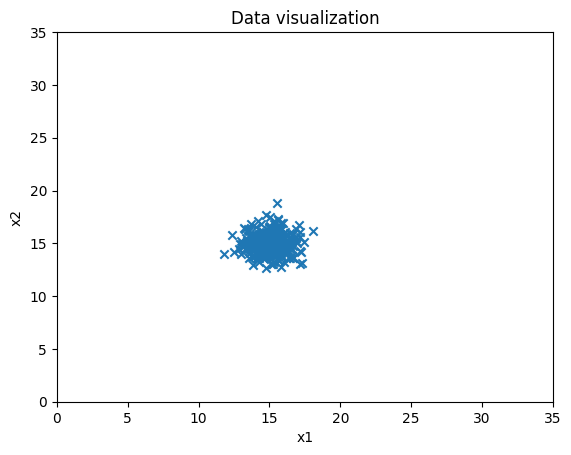

In [92]:
plt.scatter(X_train[:,0],X_train[:,1], marker='x')
plt.title('Data visualization')
plt.xlabel('x1')
plt.ylabel('x2')
plt.axis([0,35,0,35])
plt.show()

(array([  2.,  14., 175., 343.,  97.,   2.,   1.,   0.,   0.,   1.]),
 array([2.38556686, 2.48214709, 2.57872733, 2.67530756, 2.77188779,
        2.86846802, 2.96504825, 3.06162849, 3.15820872, 3.25478895,
        3.35136918]),
 <BarContainer object of 10 artists>)

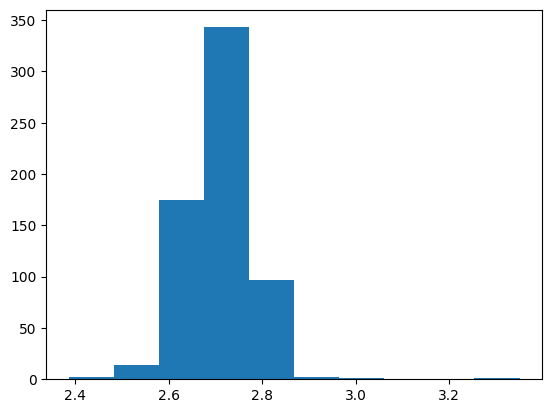

In [93]:
plt.hist(np.log(combined_data[:,0]))

### 2.3 Gaussian distribution

To perform anomaly detection, you will first need to fit a model to the data’s distribution.

* Given a training set $\{x^{(1)}, ..., x^{(m)}\}$ you want to estimate the Gaussian distribution for each
of the features $x_i$. 

* Recall that the Gaussian distribution is given by

   $$ p(x ; \mu,\sigma ^2) = \frac{1}{\sqrt{2 \pi \sigma ^2}}\exp^{ - \frac{(x - \mu)^2}{2 \sigma ^2} }$$

   where $\mu$ is the mean and $\sigma^2$ is the variance.
   
* For each feature $i = 1\ldots n$, you need to find parameters $\mu_i$ and $\sigma_i^2$ that fit the data in the $i$-th dimension $\{x_i^{(1)}, ..., x_i^{(m)}\}$ (the $i$-th dimension of each example).

### 2.3.1 Estimating parameters for a Gaussian distribution


### Estimating parameters
We can then contruct a function `estimate_gaussian` to calculate `mu` (mean for each feature in `X`) and `var` (variance for each feature in `X`). 

The estimation over these parameters, ($\mu_i$, $\sigma_i^2$), of the $i$-th
feature can be done by using the following equations. 

To estimate the mean:

$$\mu_i = \frac{1}{m} \sum_{j=1}^m x_i^{(j)}$$

and for the variance:
$$\sigma_i^2 = \frac{1}{m} \sum_{j=1}^m (x_i^{(j)} - \mu_i)^2$$


In [9]:
def estimate_gaussian(X): 
    """
    Calculates mean and variance of all features 
    in the dataset
    
    Args:
        X (ndarray): (m, n) Data matrix
    
    Returns:
        mu (ndarray): (n,) Mean of all features
        var (ndarray): (n,) Variance of all features
    """

    m, n = X.shape
     
    mu = 1/m * np.sum(X,axis=0)
    var = 1/m * np.sum((X-mu)**2, axis=0)
    
        
    return mu, var

In [70]:
mu, var = estimate_gaussian(X_train) 

print("Mean of each feature:", mu)
print("Variance of each feature:", var)

Mean of each feature: [15.00626532 14.99954687]
Variance of each feature: [0.97283974 0.93603584]


Additional functions for visualization:

In [77]:

def multivariate_gaussian(X, mu, var):
    """
    Computes the probability 
    density function of the examples X under the multivariate gaussian 
    distribution with parameters mu and var. If var is a matrix, it is
    treated as the covariance matrix. If var is a vector, it is treated
    as the var values of the variances in each dimension (a diagonal
    covariance matrix
    """
    
    k = len(mu) # Number of dimensions
    
    # If var is a vector, make it a diagonal matrix 
    if var.ndim == 1:
        var = np.diag(var)
        
    X = X - mu # Mean normalization of the data
    p = (2* np.pi)**(-k/2) * np.linalg.det(var)**(-0.5) * \
        np.exp(-0.5 * np.sum(np.matmul(X, np.linalg.pinv(var)) * X, axis=1))
    
    return p
        
def visualize_fit(X, mu, var):
    """
    This visualization shows you the 
    probability density function of the Gaussian distribution. Each example
    has a location (x1, x2) that depends on its feature values.
    """
    x = np.arange(0, 35.5, 0.5) # Coordinate vectors for the meshgrid
    y = np.arange(0, 35.5, 0.5) 
    X1, X2 = np.meshgrid(x,y) # Grid to evaluate the function. X1 and X2 represent the grid coordinates. Each pair (X1[i,j], X2[i,j]) corresponds to a point in the grid
    Z = multivariate_gaussian(np.stack([X1.ravel(), X2.ravel()], axis=1), mu, var) #Stack the matrices X1 and X2 to a suitable format for PDF evaluation.
    Z = Z.reshape(X1.shape)     

    plt.plot(X[:, 0], X[:, 1], 'bx')

    if np.sum(np.isinf(Z)) == 0:
        plt.contour(X1, X2, Z, levels=10**(np.arange(-20., 1, 3)), linewidths=1)
        
    plt.title("Gaussian contours of the distribution fit to the dataset")
  
    plt.ylabel('x1')
  
    plt.xlabel('x2')

We then can visualize the Gaussian countours of the distribution for both the $X_{train}$ and $X_{val}$ data. Remember that $X_{val}$ is used for training the model to obtain the best $\varepsilon$ basen on the $F_1$ score.

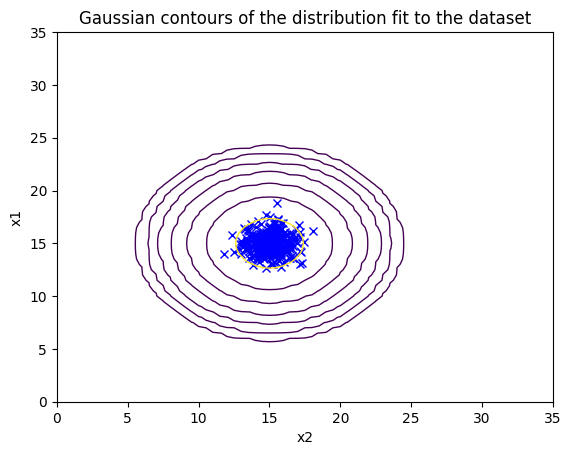

In [82]:
# Returns the density of the multivariate normal
# at each data point (row) of X_train
p = multivariate_gaussian(X_train, mu, var)

visualize_fit(X_train, mu, var)

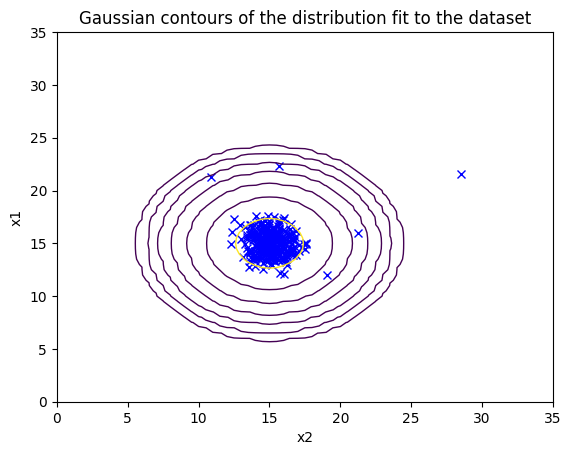

In [83]:
#Visualize the Gaussian contours for the X_val set

p_val = multivariate_gaussian(X_val, mu, var)

visualize_fit(X_val, mu, var)

### 2.3.2 Selecting the threshold $\epsilon$

Now that we have computed the Gaussian parameters, we can investigate which examples have a very high probability given this distribution and which examples have a very low probability.  Make sure to keep in mind that:

* The low probability examples are more likely to be the anomalies in our dataset. 
* One way to determine which examples are anomalies is to select a threshold based on a cross validation set using the $F_1$ score


* For this, we will use a cross validation set
$\{(x_{\rm cv}^{(1)}, y_{\rm cv}^{(1)}),\ldots, (x_{\rm cv}^{(m_{\rm cv})}, y_{\rm cv}^{(m_{\rm cv})})\}$, where the label $y=1$ corresponds to an anomalous example, and $y=0$ corresponds to a normal example. 
* For each cross validation example, we will compute $p(x_{\rm cv}^{(i)})$. The vector of all of these probabilities $p(x_{\rm cv}^{(1)}), \ldots, p(x_{\rm cv}^{(m_{\rm cv})})$ is passed to the function `select_threshold` in the vector `p_val`. 
* The corresponding labels $y_{\rm cv}^{(1)}, \ldots, y_{\rm cv}^{(m_{\rm cv})}$ are passed to the same function in the vector `y_val`.

The`select_threshold` function below them is used to find the best threshold to use for selecting outliers based on the results from the validation set (`p_val`) and the ground truth (`y_val`). 

* In the `select_threshold` function, there is already a loop that will try many different values of $\varepsilon$ and select the best $\varepsilon$ based on the $F_1$ score. 


  * Recall that if an example $x$ has a low probability $p(x) < \varepsilon$, then it is classified as an anomaly. 
        
  * Then, you can compute precision and recall by: 
   $$\begin{aligned}
   prec&=&\frac{tp}{tp+fp}\\
   rec&=&\frac{tp}{tp+fn},
   \end{aligned}$$ 
   
   where
    * $tp$ is the number of **true positives**: the ground truth label says it’s an anomaly and our algorithm correctly classified it as an anomaly.
    * $fp$ is the number of **false positives**: the ground truth label says it’s not an anomaly, but our algorithm incorrectly classified it as an anomaly.
    * $fn$ is the number of **false negatives**: the ground truth label says it’s an anomaly, but our algorithm incorrectly classified it as not being anomalous.

  * The $F_1$ score is computed using precision ($prec$) and recall ($rec$) as follows:
    $$F_1 = \frac{2\cdot prec \cdot rec}{prec + rec}$$ 

In [74]:
def select_threshold(y_val, p_val): 
    """
    Finds the best threshold to use for selecting outliers 
    based on the results from a validation set (p_val) 
    and the ground truth (y_val)
    
    Args:
        y_val (ndarray): Ground truth on validation set
        p_val (ndarray): Results on validation set
        
    Returns:
        epsilon (float): Threshold chosen 
        F1 (float):      F1 score by choosing epsilon as threshold
    """ 

    best_epsilon = 0
    best_F1 = 0
    F1 = 0
    
    step_size = (max(p_val) - min(p_val)) / 1000
    
    for epsilon in np.arange(min(p_val), max(p_val), step_size):
    
        predictions = (p_val < epsilon) # Element wise boolean evaluation. We get an array with False or True values
        
        tp = sum((predictions == 1) & (y_val == 1)) # Same as before element wise boolean evaluation. We get an array with False or True values
        fp = sum((predictions == 1) & (y_val == 0))
        fn = sum((predictions == 0) & (y_val == 1)) 
        
        # Compute Precision and Recall metrics
        prec = tp/(tp + fp)
        rec = tp/(tp + fn)
        
        #Compute F1 Score metric
        F1 = (2*prec*rec)/(prec + rec)
    
        # Select the best threshold (the bigger) and corresponding F1 score
        if F1 > best_F1:
            best_F1 = F1
            best_epsilon = epsilon
        
    return best_epsilon, best_F1

Remember the $F_1$ score metric is used when we are more focused on obtaining a balance between precision and recall. This means that **high $F_1$ score indicates a good balance between precision and recall**. A value of $F_1 = 1$ indicates a perfect balance in the classification (*ideal escenario*).

Now, we can run the Gaussian Anomaly Detection code and circle the values flagged as anomalies in the figure below.

In [84]:
epsilon, F1 = select_threshold(y_val, p_val)

print('Best epsilon found using cross-validation: %e' % epsilon)
print('Best F1 on Cross Validation Set: %f' % F1)
    

Best epsilon found using cross-validation: 1.667286e-04
Best F1 on Cross Validation Set: 1.000000


C:\Users\leora\AppData\Local\Temp\ipykernel_34288\1698826231.py:31: RuntimeWarning: invalid value encountered in scalar divide
  prec = tp/(tp + fp)


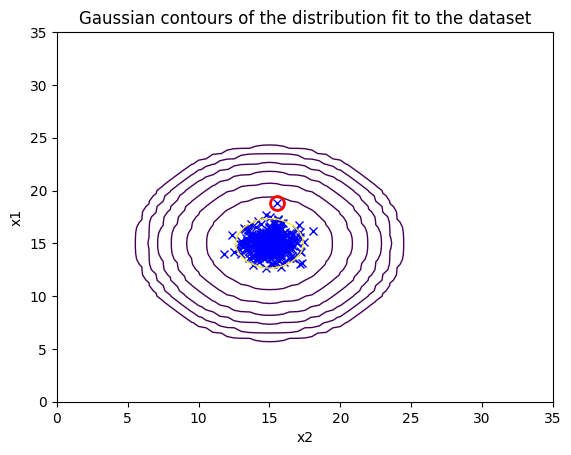

In [85]:
# Find the outliers in the training set 
outliers = p < epsilon

# Visualize the fit
visualize_fit(X_train, mu, var)

# Draw a red circle around those outliers
plt.plot(X_train[outliers, 0], X_train[outliers, 1], 'ro',
         markersize= 10, markerfacecolor='none', markeredgewidth=2)
plt.show()

In [86]:
print('Total number of anomalies found: %d'% sum(p < epsilon))

Total number of anomalies found: 1
